In [1]:
import PIL
import json
import pandas as pd
import os
import ast
import numpy as np
import cv2
from tqdm import tqdm
import random
import time

from PIL import Image, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
params = {
    'train_batch':4,
    'eval_batch':4,
    'lr':0.005
}

In [3]:
def seed_everything(seed_value=4995):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

In [6]:
class HandwrittenDataset(Dataset):
    
    def __init__(self, df, visible_char_mapping, transform = None, image_resize = (1000,500)):
        
        self.data = list(df.itertuples(index=False))
        self.transform = transform
        self.to_tensor = torchvision.transforms.ToTensor()
        
        self.visible_char_mapping = visible_char_mapping
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        sample = self.data[index]
        
        f_name = sample.filename
        image = PIL.Image.open(f_name).convert("RGB")
        #image = cv2.imread(f_name)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (800, 376))
        #image_width = image.shape[1]
        #image_height = image.shape[0]
        
        image = np.asarray(image)
        #height = sample.height
        #width = sample.width
        visible_latex_chars = sample.visible_latex_chars
        xmaxs = np.array(sample.xmaxs)
        xmins = np.array(sample.xmins)
        ymaxs = np.array(sample.ymaxs)
        ymins = np.array(sample.ymins)
        
                
        #xmins = (xmins/image_width)*1401
        #xmaxs = (xmaxs/image_width)*1401
        #ymins = (ymins/image_height)*376
        #ymaxs = (ymaxs/image_height)*376
        
        boxes = []
        for box in zip(xmins, ymins, xmaxs, ymaxs):
            boxes.append(list(box))
        
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        labels = [*map(self.visible_char_mapping.get, visible_latex_chars)]
        labels = torch.as_tensor(labels, dtype = torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        
        if self.transform:
            #image, target = self.transform(image, target)
            
            transformed_sample = self.transform(image =  image,
                                     bboxes = boxes,
                                     labels = labels)
            image = self.to_tensor(transformed_sample['image'])
            #image = transformed_sample['image']
            boxes = torch.Tensor(transformed_sample['bboxes'])
            
        else:
            image = self.to_tensor(image)
            boxes = torch.Tensor(boxes)
       
        targets = {
            'boxes':boxes,
            'labels':labels
        }

        return image, targets, f_name
    
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [7]:
def create_data_frame(raw_data, image_path):
    """
    Create a Pandas DataFrame and a list for all the latex expressions

    Parameters
    ----------
    raw_data : list
        A list that contains all the image information

    Returns
    ----------
    df: DataFrame
        A Pandas DataFrame for running the analysis
    all_latex_lst: list
        A list for all the tokens, used for creating the token distribution
    """
    data = {}
    data['latex'] = []
    data['seq_len'] = []
    data['latex_string'] = []
    data['visible_latex_chars'] = []
    data['filename'] = []
    data['width'] = []
    data['height'] = []
    data['xmins_raw'] = []
    data['xmaxs_raw'] = []
    data['ymins_raw'] = []
    data['ymaxs_raw'] = []
    data['xmins'] = []
    data['xmaxs'] = []
    data['ymins'] = []
    data['ymaxs'] = []
    
    for image in raw_data:
        data['latex_string'].append(image['latex'])
        data['latex'].append(image['image_data']['full_latex_chars'])
        data['seq_len'].append(len(image['image_data']['full_latex_chars']))
        data['visible_latex_chars'].append(image['image_data']['visible_latex_chars'])
        data['filename'].append(os.path.join(image_path, image['filename']))
        data['xmins_raw'].append(image['image_data']['xmins_raw'])
        data['xmaxs_raw'].append(image['image_data']['xmaxs_raw'])
        data['ymins_raw'].append(image['image_data']['ymins_raw'])
        data['ymaxs_raw'].append(image['image_data']['ymaxs_raw'])
        data['xmins'].append(image['image_data']['xmins'])
        data['xmaxs'].append(image['image_data']['xmaxs'])
        data['ymins'].append(image['image_data']['ymins'])
        data['ymaxs'].append(image['image_data']['ymaxs'])
        
        data['width'].append(image['image_data']['width'])
        data['height'].append(image['image_data']['height'])


    df = pd.DataFrame.from_dict(data)
    return df

In [8]:
def load_data(path = 'data/all_data.csv'):
    if not os.path.isfile(path):
        df = pd.DataFrame()
        for i in range(1,11):
            print(f'data/batch_{i}/JSON/kaggle_data_{i}.json')
            with open(file=f'data/batch_{i}/JSON/kaggle_data_{i}.json') as f:
                raw_data = json.load(f)
            sub_df = create_data_frame(raw_data, f'data/batch_{i}/background_images')
            df = df.append(sub_df)
        df.to_csv(path)
        df = pd.read_csv(path).drop(columns = 'Unnamed: 0')
    else:
        df = pd.read_csv(path).drop(columns = 'Unnamed: 0')

    list_cols = ['xmins_raw', 'xmaxs_raw', 'ymins_raw', 'ymaxs_raw', 'xmins', 'xmaxs', 'ymins', 'ymaxs']
    for c in list_cols:
        df[c] = df[c].apply(json.loads)

    df['latex'] = df['latex'].replace("'\\\\", "'\\")
    df['latex'] = df['latex'].apply(ast.literal_eval)
    
    #vocab = df['latex'].explode().unique().tolist()[0]
    df['visible_latex_chars'] = df['visible_latex_chars'].replace("'\\\\", "'\\")
    df['visible_latex_chars'] = df['visible_latex_chars'].apply(ast.literal_eval)
    
    with open(file=f'data/extras/visible_char_map.json') as f:
        visible_char_map = json.load(f)
    
    return df, visible_char_map

In [9]:
def split_dataframe(df):
    X_train, X_test = train_test_split(df, test_size=0.20, random_state=4995)
    
    return X_train, X_test

def prepare_data(batch_size = 32):
    
    df, visible_char_map = load_data()
    
    # num_classes = len(visible_char_map)
    
    l = []
    for i in df['visible_latex_chars'].tolist():
        for j in i:
            l.append(j)
    
    classes = sorted(list(set(l)))
    num_classes = len(set(l)) + 1
    
    visible_char_map = {}
    for idx, symbol in enumerate(classes):
        visible_char_map[symbol] = idx + 1 
    
    return df, visible_char_map, num_classes, classes

def build_dataloaders(df, visible_char_map, batch_size = 32):
    
    train_transforms = A.Compose([
      # A.Flip(0.5),
       # A.Resize(896, 896), 
        #A.ShiftScaleRotate(rotate_limit = 10),
        #A.Normalize(),
        A.RandomRotate90(0.5),
        #A.MotionBlur(p=0.2),
        #A.MedianBlur(blur_limit=3, p=0.1),
        #A.Blur(blur_limit=3, p=0.1),
        #ToTensorV2(p=1),
        ],
        bbox_params={
                'format': 'albumentations',
                'label_fields': ['labels']
    })
    
    val_transforms = A.Compose([
        #A.Resize(896, 896), 
        A.ShiftScaleRotate(rotate_limit = 10)

        #A.Normalize(),
    ], bbox_params={
        'format': 'albumentations', 
        'label_fields': ['labels']
    })
    
    train_df, val_df = split_dataframe(df)
    
    train_dataset = HandwrittenDataset(train_df, visible_char_map, transform = train_transforms)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=0, collate_fn = collate_fn)
    
    val_dataset = HandwrittenDataset(val_df, visible_char_map)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers=0, collate_fn = collate_fn)
    
    return train_loader, val_loader

In [10]:
def build_model(num_classes, model_path = 'models/fastrcnn.pt', to_cuda = True):
    if not model_path:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True, pretrained_backbone = True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        #model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        #    in_features=in_features, out_features=num_classes*4, bias=True
        #)
        loaded_state_dict = False

    else:
        print("Loaded", model_path)
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        model.load_state_dict(torch.load(model_path)['model_state_dict'])
        loaded_state_dict = True
        
    if to_cuda:
        model = model.to(DEVICE)
        
    return model, loaded_state_dict

In [11]:
df, visible_char_map, num_classes, classes = prepare_data()

In [12]:
from sklearn.utils import shuffle
df_shuf = shuffle(df, random_state = 1)

In [13]:
red_df = df_shuf[5000:10000]

In [14]:
test_df = df_shuf[5001:5401]

In [15]:
train_loader, val_loader = build_dataloaders(red_df, visible_char_map, batch_size = params['train_batch'])

In [16]:
_, test_loader = build_dataloaders(test_df, visible_char_map, batch_size = 1)

In [17]:
model, loaded_state_dict = build_model(num_classes)

Loaded models/fastrcnn.pt


In [20]:
for n, param in model.named_parameters():
    print(n, param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight True
backbone.body.layer2.0.conv2.weight True
backbone.body.layer2.0.conv3.weight True
backbone.body.layer2.0.downsample.0.weight True
backbone.body.layer2.1.conv1.weight True
backbone.body.layer2.1.conv2.weight True
backbone.body.layer2.1.conv3.weight True
backbone.body.layer2.2.conv1.weight True
backbone.body.layer2.2.conv2.weight True
backbone.body.layer2.2.conv3.weight True
backbone.body.layer2.3.conv1.weight True
backbone.body.layer2.3.conv2.weight True
backbone.body.layer2.3.conv3.weight True


for n, param in model.named_parameters():
    if "roi_heads.box_predictor" not in n and 'rpn.head' not in n:
        param.requires_grad = False

In [16]:
def train_loop(model, train_loader, optimizer, scheduler):
    model = model.train()
    
    train_loss_list = []
    print("Train loop")
    
    for i, data in enumerate((train_loader)):
        optimizer.zero_grad()
        images, targets, _ = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        loss = model(images, targets)
        
        losses = sum(l for l in loss.values())
        
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        
        losses.backward()
        optimizer.step()
        scheduler.step()
        
        if i % 10 == 0:
            print(f'Batch: {i} of {len(train_loader)}. Loss: {loss_value}. Mean so far: {np.mean(train_loss_list)}. Mean of 100: {np.mean(train_loss_list[-100:])}')
    
    return np.mean(train_loss_list)

In [17]:
def val_loop(model, val_loader):
    
    #model = model.eval()
    model = model.train()
    val_loss_list = []
    
    print("Validation loop")
    
    with torch.no_grad():
        for i, data in enumerate((val_loader)):
            images, targets, _ = data

            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss = model(images, targets)

            losses = sum(l for l in loss.values())

            loss_value = losses.item()
            val_loss_list.append(loss_value)
            if i % 10 == 0:
                print(f'Batch: {i} of {len(val_loader)}. Loss: {loss_value}. Mean so far: {np.mean(val_loss_list)}. Mean of 100: {np.mean(val_loss_list[-100:])}')
            
    loss_mean = np.mean(val_loss_list)
    print("Eval loss:",loss_mean)
        
    return loss_mean

In [18]:
def train(model, train_loader, val_loader, optimizer, scheduler, epochs = 5,  model_name = 'fastrcnn', save_path = 'models'):
    
    train_losses = []
    val_losses = []
    
    best_val_loss = None
    
    for epoch in range(epochs):
        if epoch > 0:
            print(f"Epoch: {epoch}")
            tic = time.time()
            train_losses.append(train_loop(model, train_loader, optimizer, scheduler))    
            print("Train loss:",train_losses[-1])
            print(f"Train loop took {time.time()-tic}")
            tic = time.time()
            val_loss = val_loop(model, val_loader)
            print(f"Validation loop took {time.time()-tic}")
            val_losses.append(val_loss)
            #scheduler.step()

            if not best_val_loss:
                best_val_loss = val_loss

                model_name_pt = model_name+'.pt'
                PATH = os.path.join(save_path, model_name_pt)
                model = model.to('cpu')
                #torch.save(model.state_dict(), PATH)
                torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                }, PATH)
                model = model.to(DEVICE)

            else:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss

                    model_name_pt = model_name+'.pt'
                    PATH = os.path.join(save_path, model_name_pt)
                    model.to('cpu')
                    torch.save(model.state_dict(), PATH)
                    model.to(DEVICE)
    
    return train_losses, val_losses

In [25]:
optimizer.load_state_dict(torch.load("models/fastrcnn.pt")['optimizer_state_dict'])

NameError: name 'optimizer' is not defined

In [58]:
torch.load("models/fastrcnn.pt")['optimizer_state_dict'].keys()

dict_keys(['state', 'param_groups'])

In [26]:
loaded_state_dict = False

l_rate = 0.0001

In [20]:
model, loaded_state_dict = build_model(num_classes, 'models/faster_fine_tuned.pt')
#for n, param in model.named_parameters():
#    if "roi_heads.box_predictor" not in n and 'rpn.head' not in n:
#        param.requires_grad = False

loaded_state_dict = False

l_rate = 0.0005

train_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(train_params, lr = l_rate, weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * 5)
if loaded_state_dict:
    optimizer.load_state_dict(torch.load("models/fastrcnn.pt")['optimizer_state_dict'])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,4], gamma = 0.1)
    scheduler.load_state_dict(torch.load("models/fastrcnn.pt")['optimizer_state_dict'])

train_losses, val_losses = train(model, train_loader, val_loader, optimizer, scheduler, epochs = 5, model_name = 'faster_fine_tuned')

Loaded models/faster_fine_tuned.pt
Epoch: 1
Train loop


/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Batch: 0 of 1000. Loss: 0.47070491313934326. Mean so far: 0.47070491313934326. Mean of 100: 0.47070491313934326
Batch: 10 of 1000. Loss: 0.8043540716171265. Mean so far: 1.1635194149884311. Mean of 100: 1.1635194149884311
Batch: 20 of 1000. Loss: 0.4100603461265564. Mean so far: 0.7954288678509849. Mean of 100: 0.7954288678509849
Batch: 30 of 1000. Loss: 0.24989400804042816. Mean so far: 0.6627031781019703. Mean of 100: 0.6627031781019703
Batch: 40 of 1000. Loss: 0.33181989192962646. Mean so far: 0.5845933705568314. Mean of 100: 0.5845933705568314
Batch: 50 of 1000. Loss: 0.38158708810806274. Mean so far: 0.5401317123688903. Mean of 100: 0.5401317123688903
Batch: 60 of 1000. Loss: 0.2816970646381378. Mean so far: 0.5179167822247646. Mean of 100: 0.5179167822247646
Batch: 70 of 1000. Loss: 0.4291877746582031. Mean so far: 0.49291406613840183. Mean of 100: 0.49291406613840183
Batch: 80 of 1000. Loss: 0.4333231449127197. Mean so far: 0.4749900843994117. Mean of 100: 0.4749900843994117
Bat

KeyboardInterrupt: 

In [23]:
def test_loop(model, test_loader):
    
    model = model.eval()
    test_loss_list = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            images, targets, _ = data

            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            out = model(images, targets)

            losses = sum(l for l in loss.values())

            loss_value = losses.item()
            val_loss_list.append(loss_value)
            
    loss_mean = np.mean(val_loss_list)
    print("Eval loss:",loss_mean)
        
    return loss_mean

In [31]:
val_loop(model, val_loader)

Validation loop
Batch: 0 of 125. Loss: 0.4335559010505676
Batch: 10 of 125. Loss: 0.3930650055408478


KeyboardInterrupt: 

In [41]:
def add_text_border(draw_obj, font, text, xmin, ymin):
    """
    Add a thin black border around the text, helps with visualization. Modifies the draw object in place.
    
    Parameters
    ----------
    draw_obj : PIL.ImageDraw.ImageDraw
        The draw object.
    font : PIL.ImageFont.FreeTypeFont
        The ImageFont to add a border to.
    text : str
        The precise text being outlined, generally the label.
    xmin, ymin: int
        The xmin and ymin for the starting point of the text. (Top-Left)
    
    Returns
    ----------
    None
    """
    # Add a thin border.
    draw_obj.text((xmin-2, ymin), text, font=font, fill="black")
    draw_obj.text((xmin+2, ymin), text, font=font, fill="black")
    draw_obj.text((xmin, ymin-2), text, font=font, fill="black")
    draw_obj.text((xmin, ymin+2), text, font=font, fill="black")

def draw_bounding_boxes_on_image(img, xmins, ymins, xmaxs, ymaxs, labels):
    """
    Draws and labels bounding boxes on source image using ground truth lists of details pertaining to the source image. Modifies the source image in place.
    
    Parameters
    ----------
    img : PIL.Image.Image
        The source image.
    xmins, ymins, xmaxs, ymaxs : list
        A list of the respectful coordinates for the image
    labels : list
        A list of labels for each character to be drawn.

    Returns
    ----------
    None
    """
    draw_obj = ImageDraw.Draw(img)
    font_file = "/kaggle/input/ocr-data/extras/single_example/Roboto-Regular.ttf"
    font = ImageFont.truetype(font_file, 32)
    for xmin, ymin, xmax, ymax, label in zip(xmins, ymins, xmaxs, ymaxs, labels):
        draw_obj.rectangle([xmin, ymin, xmax, ymax], width=3)
        text = str(label.item())
        add_text_border(draw_obj, font, text, xmin, ymin)
        draw_obj.text((xmin, ymin), text, font=font)
        
def visualize_predictions(model, loader, num_samples = 5, detection_threshold=0.5):
    model.eval()
    for i, samp in enumerate(test_loader):
        if i == num_samples:
            break
        images, targets, img_file = samp
        images = list(img.to(DEVICE) for img in im)
        
        with torch.no_grad():
            outputs = model(images)
        
        boxes = outputs[0]['boxes'].cpu().data.numpy()
        scores = outputs[0]['scores'].cpu().data.numpy()
        
        #image = cv2.imread(img_file[0])
        #orig_image = image.copy()
        #image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        #boxes = boxes[scores >= detection_threshold].astype(np.int32)
        #draw_boxes = boxes.copy()
        
        xmins = boxes[:,1]
        ymins = boxes[:,3]
        xmaxs = boxes[:,0]
        ymaxs = boxes[:,2]
        
        labels = out[0]['labels']
        
        img_fil = img_file[0]
        img_display = Image.open(img_fil)
        #img_display = img_display.resize((896, 896))
        
        """
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)

        cv2.imshow('Prediction', orig_image)
        """
        
        draw_bounding_boxes_on_image(img_display, xmins, ymins, xmaxs, ymaxs, labels)
        
        display(img_display)
        
    

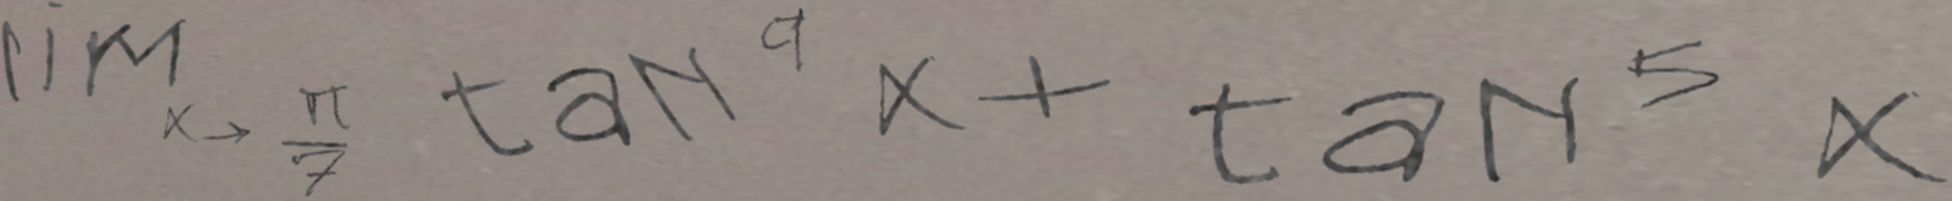

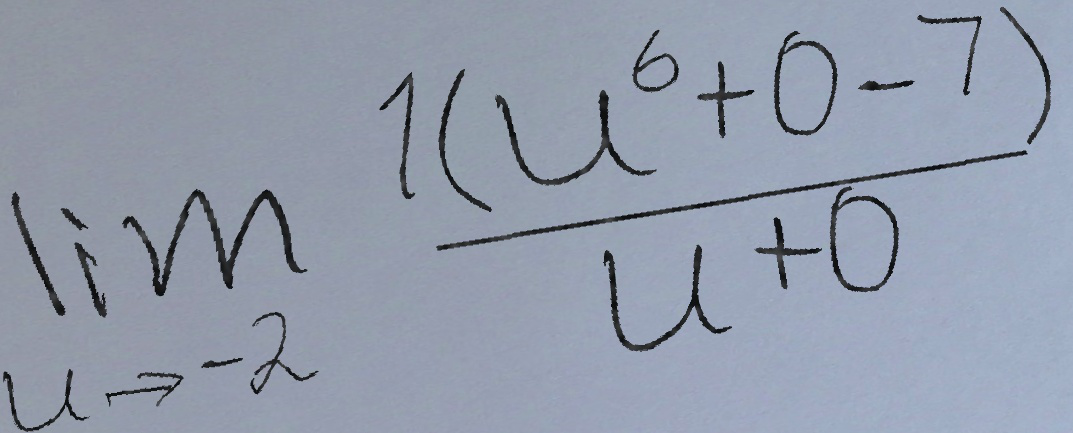

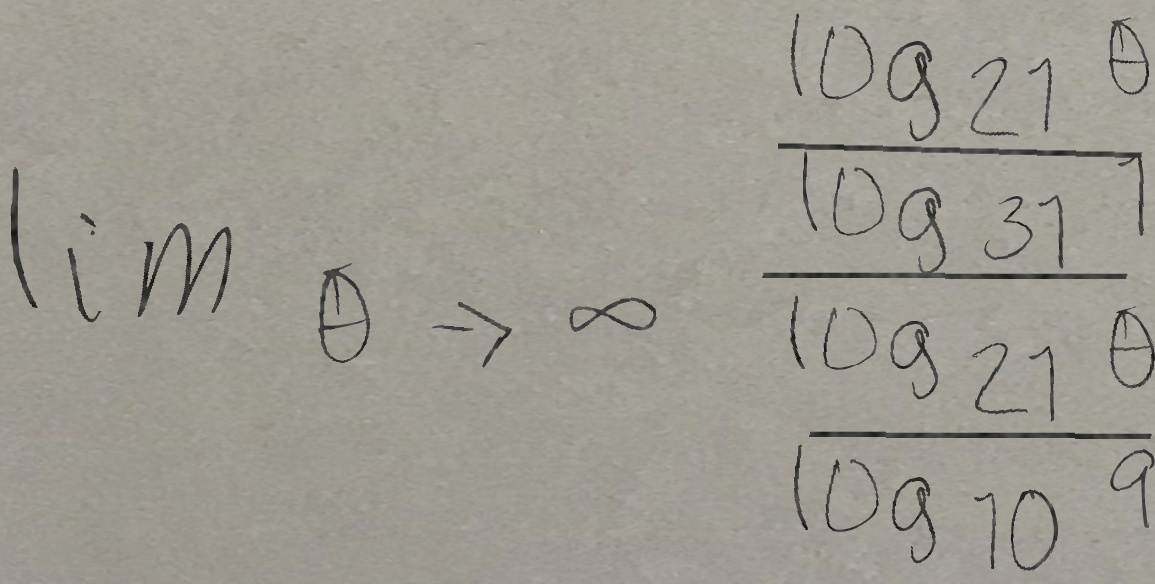

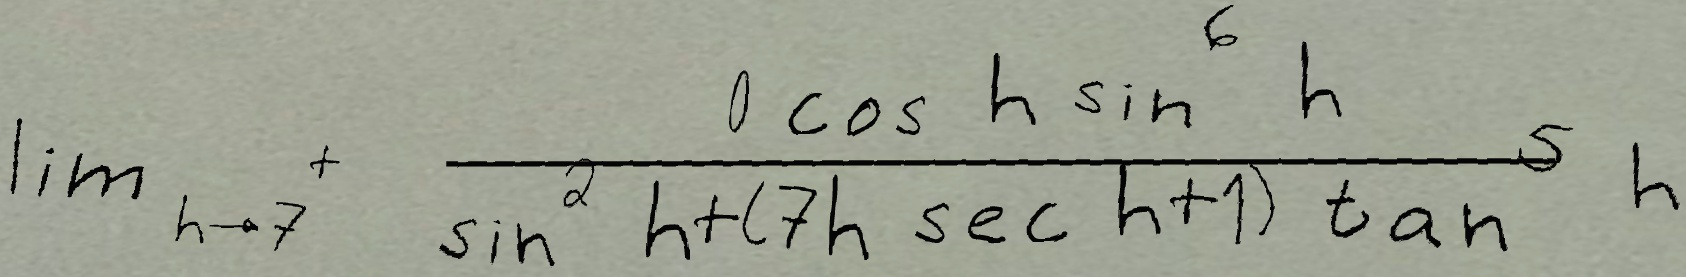

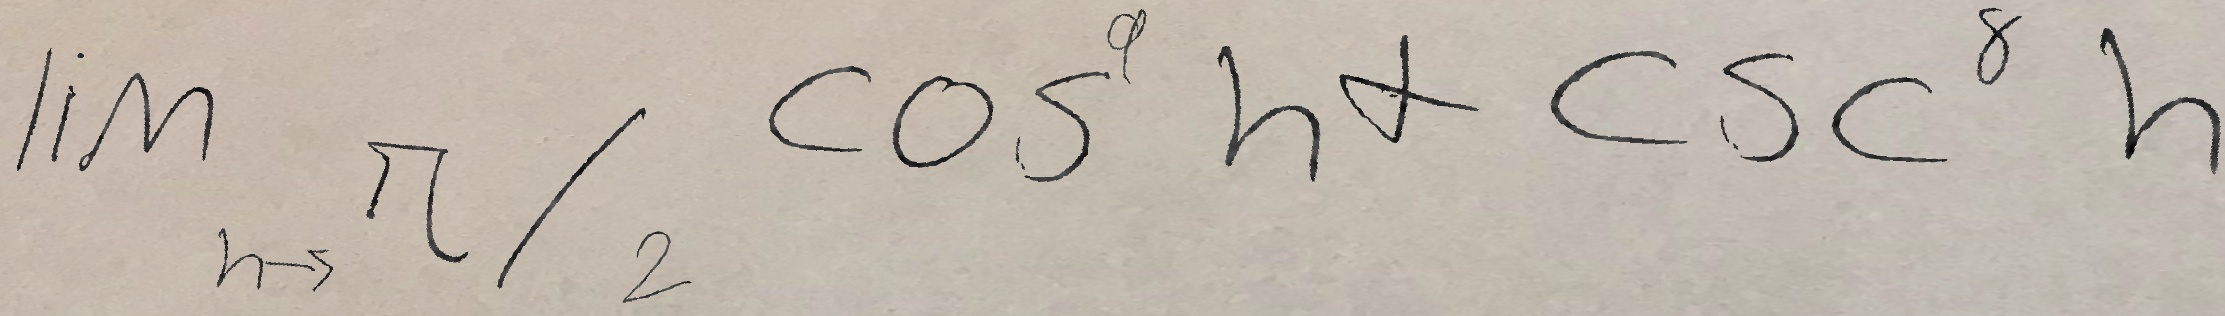

In [42]:
visualize_predictions(model, test_loader)

In [33]:
for i in test_loader:
    break

In [34]:
model = model.eval()

In [35]:
im, targets,_ = i

In [36]:
images = list(img.to(DEVICE) for img in im)

In [37]:
out = model(images)

In [38]:
out

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [18]:
df.width.mean(), df.height.mean()

(1401.68117, 376.78104)